## Generating the data
In order to test your algorithm, you need to generate datasets. You are free to come up with your own ideas to generate datasets. 

Basically pick an n-length segment from Sars-Cov2 genome as your root node, perform random insertions, deletions and substitutions to construct the
ground truth phylogenetic tree. 

Now given the root and the list of all observed genomes (in some random order), you will have to reconstruct the minimum cost tree which explains the observations. Of course, the minimum cost tree may not be the same as the ground truth.

In [1]:
# Import libraries/modules
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import networkx as nx
from networkx.algorithms.approximation import steiner_tree

In [2]:
with open('sars_cov2_genome.txt', 'r') as myfile:
    data = myfile.read()

cov2_genome_list = []

for i in range(len(data)):
    if data[i] != '\n':
        cov2_genome_list.append(data[i])
    
cov2_genome_array = np.asarray(cov2_genome_list)

In [3]:
# Simulate a deletion channel

def deletion(seq, delta):
    """
    Takes in a sequence and returns a deleted version,
    where each symbol is deleted with probability delta
    
    Parameters
    ----------
    - seq: 1-D numpy array corresponding to the sequence
    - p: deletion probability, a real number in [0,1]
    
    Returns
    -------
    - out: 1D numpy array which is a deleted version of seq
    
    """
    index = 0
    to_be_deleted = [] # initialize counting variables
    # If the variable delete = 1 then the symbol at that index will be deleted
    for i in seq:
        # Set the variable delete as 1 with probability delta 
        delete = np.random.choice([True,False],p=[delta,(1-delta)])
        # All indexes t be deleted will be deleted once after the for loop for efficiency
        if delete:
            to_be_deleted.append(index)
        index = index + 1
    out = np.delete(seq, to_be_deleted)
    return out

In [4]:
# Simulate substitution channel

def sub(seq, delta):
    """
    Takes in a sequence and returns a deleted version,
    where each symbol is substituted with probability delta
    
    Parameters
    ----------
    - seq: 1-D numpy array corresponding to the sequence
    - p: substitution probability, a real number in [0,1]
    
    Returns
    -------
    - out: 1D numpy array which is a substituted version of seq
    
    """
    index = 0 # index counter
    to_be_subbed = [] # initialize counting variables
    
    # If the variable sub == 1 then the symbol at that index 
    # will be substitued with another random base
    
    for i in seq:
        # Set the variable sub as 1 with probability delta 
        sub = np.random.choice([True,False],p=[delta,(1-delta)])
        # All indexes t will be substituted once 
        # after the for loop for efficiency
        if sub:
            to_be_subbed.append(index)
        index = index + 1
    
    bases = np.asarray(['A','T','G','C'])
    out = seq
    for i in to_be_subbed:
        # Pick random base excluding base already at that index
        random_base = random.choice(bases[bases != out[i]])
        # Replace base in seq at index i with the random base
        np.put(out, i, random_base)
    
    return out

In [5]:
# Simulate insertion channel

def insertion(seq, delta):
    """
    Takes in a sequence and returns a inserted version,
    where each a symbol is inserted at each index with probability delta
    
    Parameters
    ----------
    - seq: 1-D numpy array corresponding to the sequence
    - p: insertion probability, a real number in [0,1]
    
    Returns
    -------
    - out: 1D numpy array which is an inserted version of seq
    
    """
    index = 0
    to_be_inserted = [] # initialize counting variables
    
    # If the variable insert = 1 then a new random symbol will be inserted at that index
    for i in seq:
        # Set the variable insert as 1 with probability delta 
        insert = np.random.choice([True,False],p=[delta,(1-delta)])
        # After the for loop, a random base will be inserted at each index
        if insert:
            to_be_inserted.append(index)
        index = index + 1
    
    bases = np.asarray(['A','T','G','C'])
    out = seq
    for i in to_be_inserted:
        random_base = random.choice(bases)
        out = np.insert(seq, i, random_base)
        
    return out

In [6]:
# Function to format graph to look like tree

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [7]:
# edit distance function from HW3
def edit_dist(A, B):
    """
    Given two strings, compute edit distance (number of insertions, deletions, substitutions
    to transform one vector into the other).
    
    Parameters
    ----------
    - A: string of length N1
    - B: string of length N2
    
    Returns
    -------
    - edit distance between A and B
    
    """
    #lengths of the sequences
    N1 = len(A)
    N2 = len(B)
    
    table = np.zeros((N1+1,N2+1))
    
    for i in range(N1+1):
        for j in range(N2+1):
            #find values for which first row and column(empty strings) are compared with the sequence
            if j==0:
                table[i][j] = i
            elif i==0:
                table[i][j] = j
            
            #If last cahracters of a base match then the difference value is the same as its diagonal value
            elif A[i-1]==B[j-1]:
                table[i][j] = table[i-1][j-1]
            #If last cahracters dont match then the next table value is equal to
            #1+ the minimum of the left-diagonal,upper-left cells
            else:
                table[i][j] = 1 + min(table[i][j-1],table[i-1][j-1],table[i-1][j])
    
    #edit distance is the value of the last cell
    ed = table[N1][N2] 
                
    
    
    return ed , table

In [8]:
# Generate ground truth tree from given genome and sequence length, n
# Return ground truth tree graph and required data

def ground_truth_tree(genome, n, 
                      Pd, Ps, Pi, 
                      max_mut_branch, 
                      max_generations):
    """
    Pick a random n length segment from the genome.
    The genome must be a 1-D numpy array.
    Perform a random number of insertions, deletions and substitutions
    to construct the ground truth phylogenetic tree.
    
    *Other inputs:
    -> Pd = P(deletion)
    -> Ps = P(substitution)
    -> Pi = P(insertion)
    
    -> max_generations is the total number of layers in the tree graph
    
    -> max_mut_branch is the max number of mutations that will occur at each branch
        A random number between 0 and max_mut_branch is the number of mutations to actually
        occur at each branch. The type of mutation is also decided randomly.
    
    *Return:
    -> root: the root node (n length segment) 
    -> edges: the tree with all mutations (a list of lists where each sublist contains the connected vertices)
    -> rand_vertices: list of all observed mutations in random order
    """
    # Pick random n-length segment from the genome
    start_index = random.randrange(genome.size - n)
    root = genome[start_index:start_index+n]
    
    edges = [] #list of lists to store adjecent verdices in
    
    generations = [[[]]]  #[ [ [generation 0 root node] ], [ [generation 1 node A], [generation 1 node B] ] etc] 
    generations[0] = [root.tolist()] 
    
    current_gen = 0
    while len(generations) < max_generations:
        
        generations.append([])
        for i in generations[current_gen]:
            
            node = np.asarray(i) #convert list to np array to use with functions
            mutations = random.randrange(1,max_mut_branch+1) # randomly pick the number of mutations to occur at this node
            
            for j in range(mutations):
                
                mut_type = random.randrange(3) # randomly pick the type of mutation
                
                if mut_type == 0:
                    new_node = deletion(node,Pd)
                    
                elif mut_type == 1:
                    new_node = sub(node,Ps)
                    
                elif mut_type == 2:
                    new_node = insertion(node, Pi)
                
                generations[current_gen+1].append(new_node.tolist())
                edges.append((''.join(i),''.join(new_node.tolist())))
        
        current_gen = current_gen + 1
    
    rand_vertices = []
    for i in generations:
        for j in i:
            rand_vertices.append(''.join(j))
    random.shuffle(rand_vertices)
    
    root = ''.join(root)
    
    DG = nx.Graph() #undirected graph, directed graphs don't work with hierarchy_pos
    DG.add_edges_from(edges)
    
    if (nx.is_tree(DG)==False):
        restart = True
        #print("restart")
        return 0, 0, 0, 0, True
    
    elif (nx.is_tree(DG)==True):
        restart = False
        #print("Is a tree graph: ",nx.is_tree(DG),"\n\n") # will throw an error in hierarchy_pos if not tree graph

        # Print the data
        #print("Root node")
        #print(root)
        #print("\n\nEdges")
        #print(edges)
        #print("\n\nVertices in random order")
        #print(rand_vertices)

        #Plot the tree:        
        edge_labels = {} # store edit distances in dictionary
        for edge in edges:
            edge_labels[edge],_ = edit_dist(edge[0],edge[1])
        total_edit_dist = sum(edge_labels.values()) # sum of the edit distances of all the edges

        pos = hierarchy_pos(DG, root, width=1) # Format graph to look like a tree with root as the root node

        plt.figure(figsize=(20,12)) # figszie = (width,height)  change for bigger graphs
        nx.draw_networkx(DG, pos=pos, with_labels=True, font_weight='bold', node_color='lightcyan', node_size=8000, font_size=12)
        nx.draw_networkx_edge_labels(DG, pos=pos, edge_labels=edge_labels, font_weight='bold', font_size=14) # add edge labels to graph

        plt.title("Ground Truth Tree")

        plt.annotate('Total edge cost = %i' %total_edit_dist, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=18, fontweight='bold')

        plt.show()

        return ''.join(root), edges, rand_vertices, total_edit_dist, restart

    
    

## Find minimum cost tree

In [9]:
#Find where each mutation happened using the edit distance table(the method described in class)
#Uses 2 variables x and y to navigate through the table where the minimum value is located 
def find_mut(table):
    
    l1 = len(table)
    l2 = len(table[0])
    R = l1
    x = 1
    y = 1
    ind = []
    for i in range(R+x+y):
        comp = [table[l1-1-x][l2-1-y],table[l1-x][l2-1-y],table[l1-1-x][l2-y]]        
        
        if comp.index(min(table[l1-1-x][l2-1-y],table[l1-x][l2-1-y],table[l1-1-x][l2-y])) == 0:
            if table[l1-1-x][l2-1-y] != table[l1-x][l2-y]:
                #print(table[l1-x][l2-1-y],table[l1-1-x][l2-1-y],table[l1-1-x][l2-y])
                #print('There are ' + str(table[l1-x][l2-y] - table[l1-1-x][l2-1-y])+ ' substitutions')
                ind.append([l1-x , l2-y])
            x += 1
            y += 1
            
        elif comp.index(min(table[l1-1-x][l2-1-y],table[l1-x][l2-1-y],table[l1-1-x][l2-y])) == 1:
            if table[l1-x][l2-1-y] != table[l1-x][l2-y]:
                #print(table[l1-x][l2-1-y],table[l1-1-x][l2-1-y],table[l1-1-x][l2-y])
                #print('There are ' + str(table[l1-x][l2-y] - table[l1-x][l2-1-y])+ ' insertions')
                ind.append([0 , l2-y])
            y += 1
            
        elif comp.index(min(table[l1-1-x][l2-1-y],table[l1-x][l2-1-y],table[l1-1-x][l2-y])) == 2:
            if table[l1-1-x][l2-y] != table[l1-x][l2-y]:
                #print(table[l1-x][l2-1-y],table[l1-1-x][l2-1-y],table[l1-1-x][l2-y])
                #print('There are ' + str(table[l1-x][l2-y] - table[l1-1-x][l2-y])+ ' deletions')
                ind.append([l1-x , 0])
            x += 1
        if l1-x == 0 and l2-y == 0 :
            break
        
    
    return ind #returns the indexes to be used later

In [10]:
#By inputing the strings and using ed_dist and find_mut it finds the type of the mutation occured and at what position 
def muted(edges):
    
    dictionary = {}
    l = len(edges)
    for i in range(l):
        ed = edit_dist(edges[i][0],edges[i][1])
        stri = 'Edit dist = %i\n' %ed[0]
        f = find_mut(ed[1])
        for j in range(len(f)):
            if f[j][0] != 0 and f[j][1] != 0:
                #print('A base ' + edges[i][0][f[j][0]] + ' was substituted with a ' + edges[i][1][f[j][1]] + ' in the position ' + str(f[j][0]+1))
                #stri += 'A base ' + edges[i][0][f[j][0]-1] + ' was substituted with a ' + edges[i][1][f[j][1]-1] + ' in the position ' + str(f[j][0]) + ' \n '
                stri += edges[i][0][f[j][0]-1] + ' subbed with ' + edges[i][1][f[j][1]-1] + ' in position ' + str(f[j][0]) + '\n'
            if f[j][0] != 0 and f[j][1] == 0:
                #print('A base ' + edges[i][0][f[j][0]] + ' was deleted in the position ' + str(f[j][0]+1))
                #stri += 'A base ' + edges[i][0][f[j][0]-1] + ' was deleted in the position ' + str(f[j][0])+ ' \n '
                stri += edges[i][0][f[j][0]-1] + ' deleted in position ' + str(f[j][0])+ '\n'
            if f[j][0] == 0 and f[j][1] != 0:
                #print('A base ' + edges[i][1][f[j][1]] + ' was inserted in the position ' + str(f[j][1]+1))
                #stri += 'A base ' + edges[i][1][f[j][1]-1] + ' was inserted in the position ' + str(f[j][1]) + ' \n '
                stri += edges[i][1][f[j][1]-1] + ' inserted in position ' + str(f[j][1]) + '\n'
            if f[j][0] == 0 and f[j][1] == 0:
                #stri += 'A base ' + edges[i][1][f[j][1]] + ' was inserted in the beggining \n '
                stri += edges[i][1][f[j][1]] + ' inserted at start \n'
        dictionary[edges[i]] = stri
    return dictionary

In [11]:
#Finds the similarity between 2 trees by inputing their edges
def mut_diff(ground_edges_list,steiner_edges_list):
    common = list(set(ground_edges_list).intersection(steiner_edges_list))
    correct = len(common)
    ratio = (correct/len(ground_edges_list))*100
    return ratio


In [12]:
#Plots the minimum cost tree and returns some values for data analysis
def minimum_cost_tree(n, max_generations):
    '''
    Inputs:
    n is segment length
    max_generations is max number of generations in ground truth tree
    
    Plots:
    Ground truth tree diagram
    Minimum cost tree diagram with and without edge labels
    
    Outputs:
    Number of vertices: num_vertices
    Total costs of Steiner and Ground truth trees: steiner_cost, ground_cost
    Time to find minimum cost tree: steiner_time
    Similarity ratio between ground truth and min cost tree: similarity    
    '''
    
    genome = cov2_genome_array
    Pd = 0.2
    Ps = 0.2
    Pi = 0.2
    max_mut_branch = 2

    restart = True
    while(restart):
        root, edges, vertices, ground_cost, restart = ground_truth_tree(genome, n, 
                                                                        Pd, Ps, Pi, 
                                                                        max_mut_branch, 
                                                                        max_generations)
   
    num_vertices = len(vertices)
    # Make complete graph with the vertices of the ground truth tree
    complete_graph = nx.complete_graph(vertices)
    
    # Compute edit distance of each of the edges and save as weights
    for e in complete_graph.edges():
        complete_graph[e[0]][e[1]]['weight'],_ = edit_dist(e[0],e[1])
        
    # Perform networkx steiner function on complete graph
    start_time = time.time()
    # Time this line
    steiner = steiner_tree(complete_graph, vertices, weight='weight')
    steiner_time = time.time() - start_time
    
    # Compute total cost of min cost tree from steiner
    steiner_cost = 0
    for edge_weight in steiner.edges.data('weight'):
        steiner_cost += edge_weight[2]
    
    similarity = mut_diff(list(edges), list(steiner.edges()))
    
    
    # Plot the minimum cost tree without and with edges labels
    directed_tree = nx.bfs_tree(steiner,root)
    
    plt.figure(figsize=(20,12))
    pos = hierarchy_pos(steiner, root, width=1) # Format graph to look like a tree with segment as the root node
    nx.draw_networkx(steiner, pos, with_labels=True, font_weight='bold', node_color='lightcyan', font_size=12)
    plt.annotate('Total edge cost = %i' %steiner_cost, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=18, fontweight='bold')
    plt.title("Minimum cost tree")  
    plt.show()
    
    for e in directed_tree.edges():
        directed_tree[e[0]][e[1]]['weight'],_ = edit_dist(e[0],e[1])
    edge_labels_dict = muted(list(directed_tree.edges()))
    
    plt.figure(figsize=(20,12))
    pos = hierarchy_pos(steiner, root, width=1) # Format graph to look like a tree with segment as the root node
    nx.draw_networkx(steiner, pos, with_labels=True, font_weight='bold', node_color='lightcyan', font_size=12)
    nx.draw_networkx_edge_labels(steiner,pos=pos,edge_labels=edge_labels_dict, font_size=8, label_pos=0.5,clip_on=False)
    plt.annotate('Total edge cost = %i' %steiner_cost, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=18, fontweight='bold')
    plt.title("Minimum cost tree\nWith edge labels")  
    plt.show()
    
    
    return num_vertices, steiner_cost, ground_cost, steiner_time, similarity

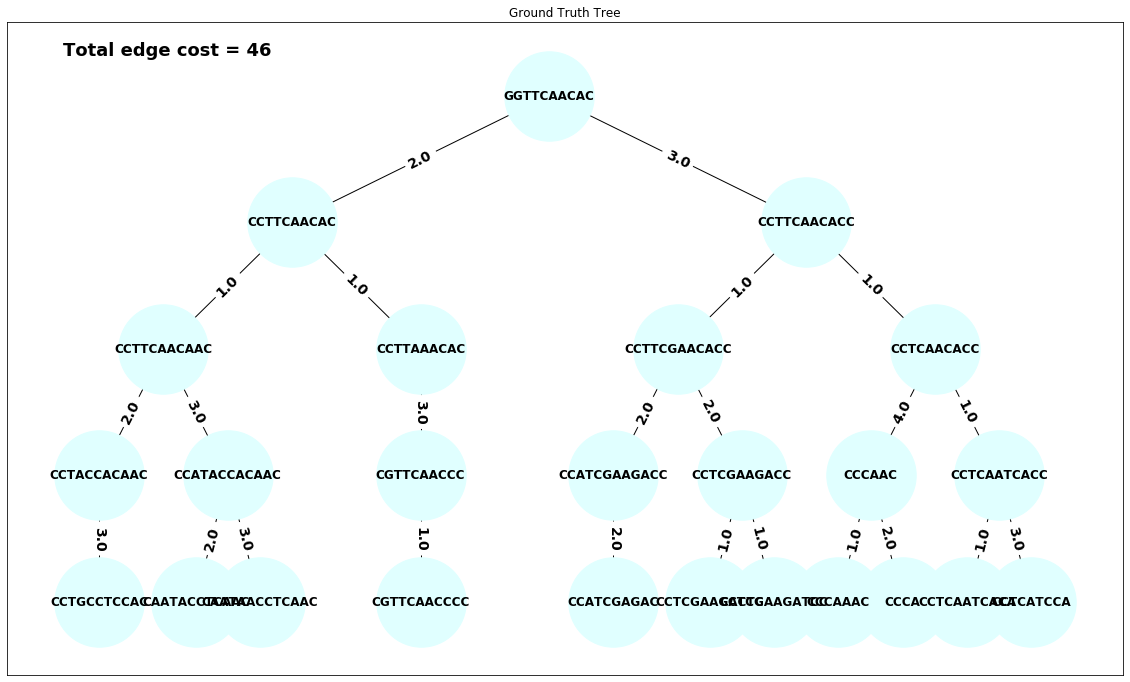

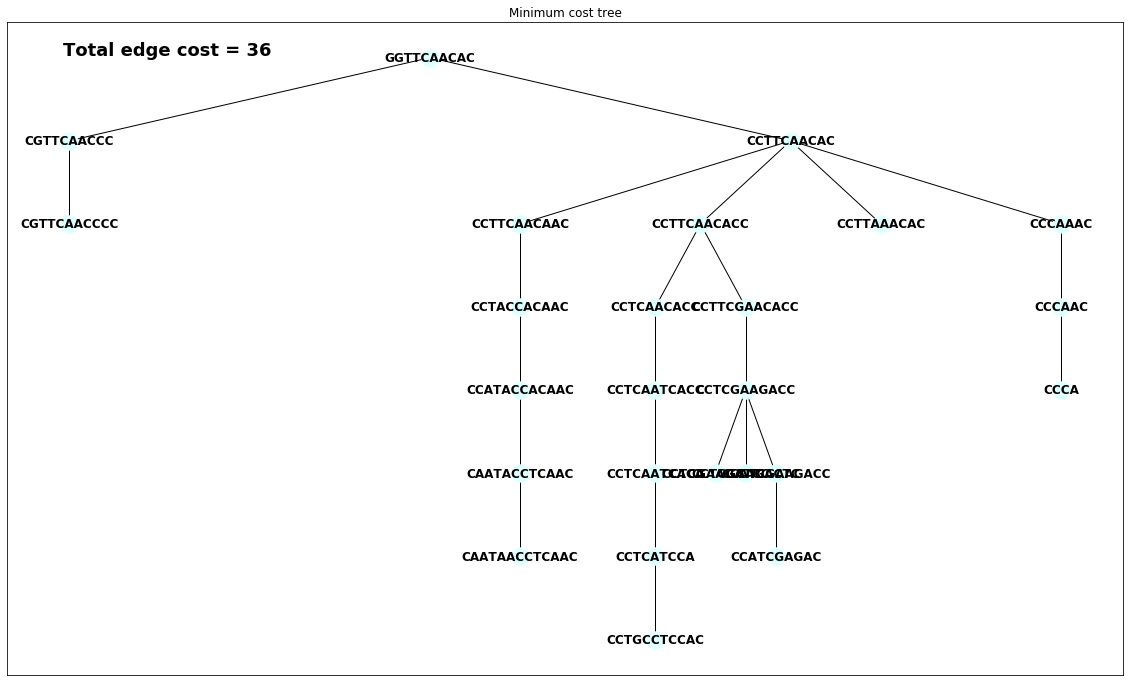

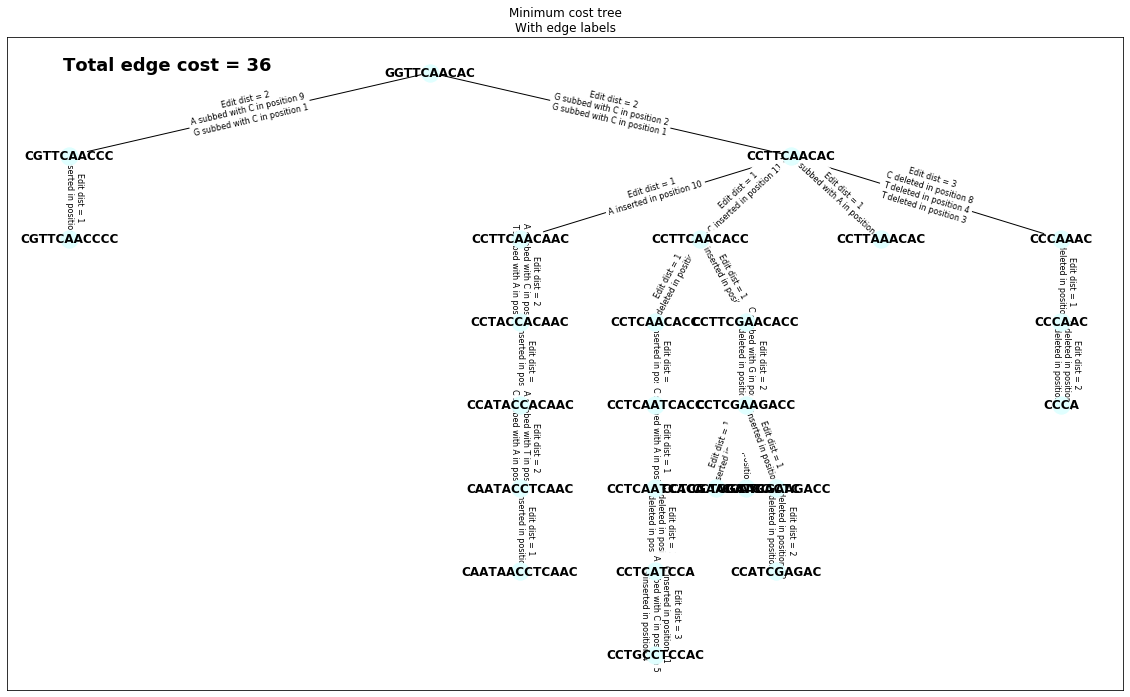

In [13]:
num_vertices, steiner_cost, ground_cost, steiner_time, similarity = minimum_cost_tree(10,5)

In [14]:
print(num_vertices)
print(steiner_cost)
print(ground_cost)
print(steiner_time)
print(similarity)

25
36.0
46.0
0.011967182159423828
41.66666666666667


In [ ]:
# Finds the data to be used for plotting

n = [ 5,10,15,20,40,100]
gen = [4,6,8]
rep = 50
verta = np.zeros([len(n),len(gen)])
timea = np.zeros([len(n),len(gen)])
sima = np.zeros([len(n),len(gen)])
costa = np.zeros([len(n),len(gen)])

for k in range(rep):
    verto = []
    timeo = []
    simo = []
    costo = []
    for i in range(len(n)):
        vert = []
        tim = []
        sim = []
        cost = []
        for j in range(len(gen)):
            num_vertices, steiner_cost, ground_cost, steiner_time, similarity = minimum_cost_tree(n[i], gen[j])
            vert.append(num_vertices)
            tim.append(steiner_time)
            sim.append(similarity)
            cost.append(ground_cost - steiner_cost)
        verto.append(vert)
        timeo.append(tim)
        simo.append(sim)
        costo.append(cost)
    verto = np.array([np.array(xi) for xi in verto])
    timeo = np.array([np.array(xi) for xi in timeo])
    simo = np.array([np.array(xi) for xi in simo])
    costo = np.array([np.array(xi) for xi in costo])
    verta = np.add(verta,verto)
    timea = np.add(timea,timeo)
    sima = np.add(sima,simo)
    costa = np.add(costa,costo)
    
#Averages the values of the multiple repetitions
Avert = verta/rep
Atime = timea/rep
Asim = sima/rep
Acost = costa/rep

In [16]:
#Data used for plotting. Matrices where each row corresponds to a different segment length and each column to 
# a different maximum number of generations
print(Avert)
print(Atime)
print(Asim)
print(Acost)

[[ 6.18  9.18 12.4 ]
 [ 7.48 12.48 17.5 ]
 [ 7.68 15.98 24.92]
 [ 8.58 19.7  31.32]
 [ 8.   20.58 53.74]
 [ 7.84 19.44 46.12]]
[[0.00079759 0.00171598 0.00372568]
 [0.00107908 0.00479613 0.01166759]
 [0.00119499 0.00724494 0.02818478]
 [0.00133721 0.01632029 0.07268081]
 [0.00121788 0.01593819 0.1957023 ]
 [0.00096825 0.01150338 0.13405237]]
[[40.30714286 37.83357802 34.59612683]
 [37.62324342 36.10211737 38.69383662]
 [38.99245754 39.00719115 36.50549194]
 [39.45525031 35.86154757 38.69127784]
 [40.03066933 38.64322711 36.76799239]
 [40.02043512 40.59915748 38.59001793]]
[[ 0.86  1.56  2.24]
 [ 1.78  3.52  4.5 ]
 [ 2.38  4.78  8.56]
 [ 3.38  8.82 13.58]
 [ 4.2  13.88 36.56]
 [10.9  24.4  63.62]]


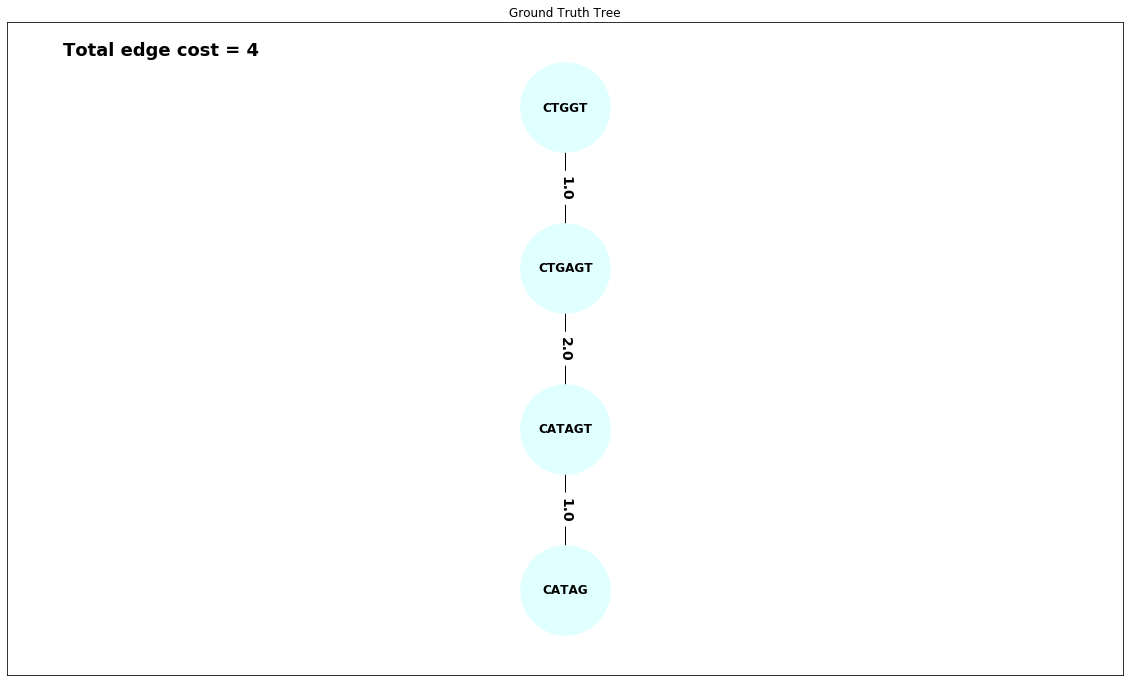

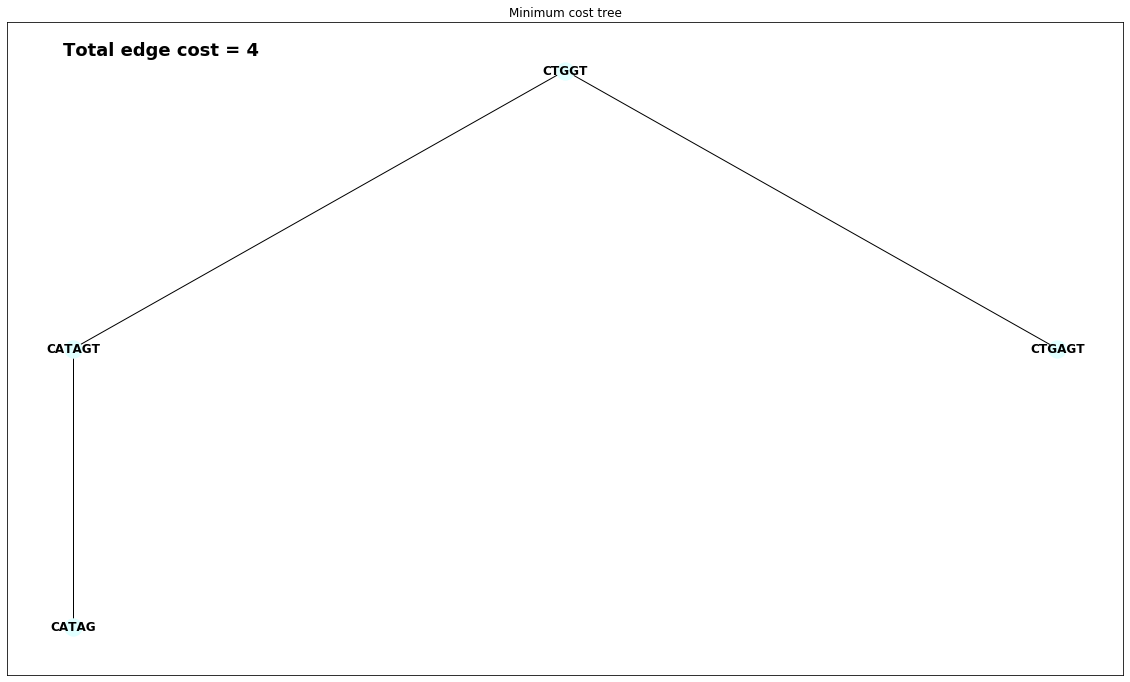

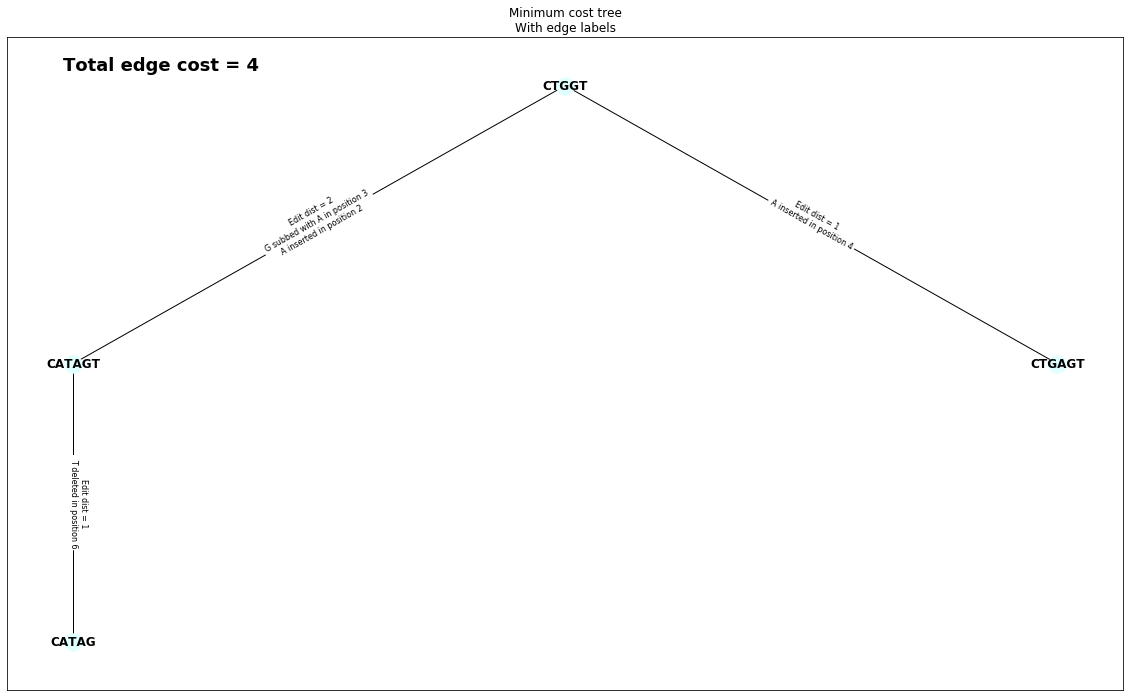

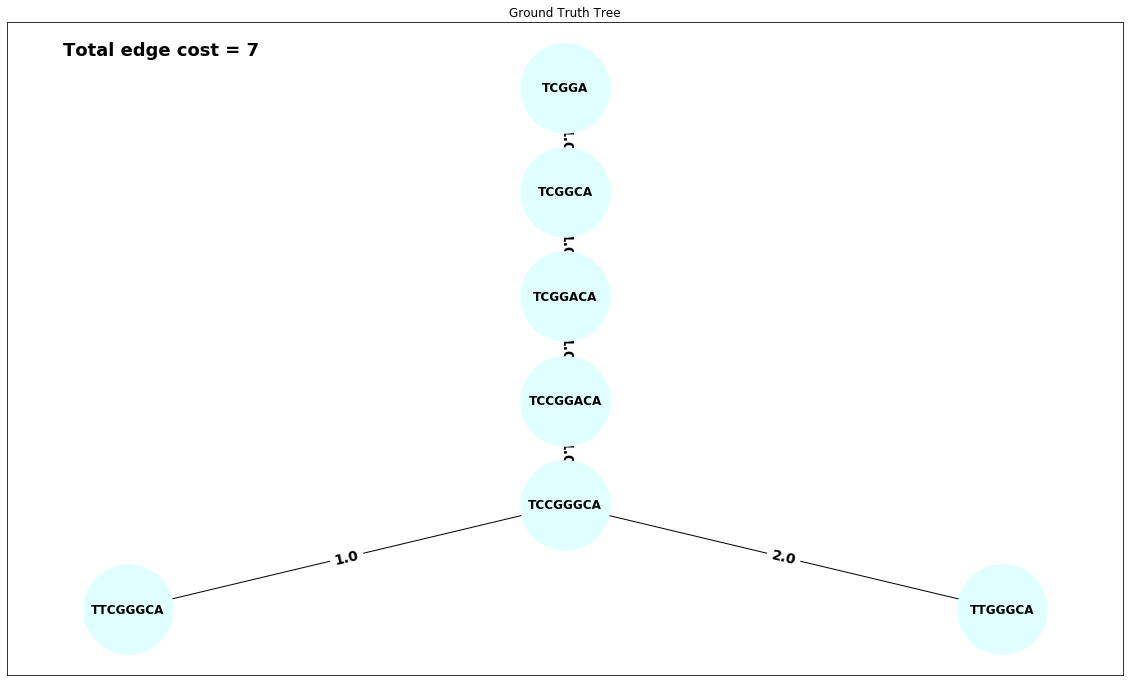

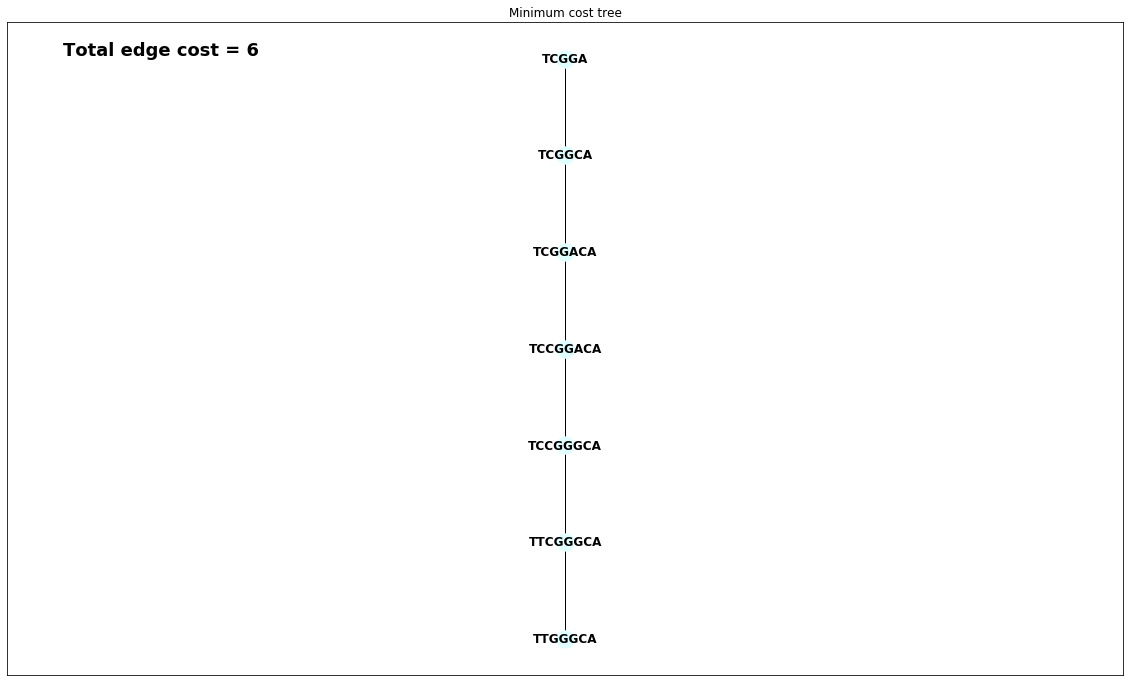

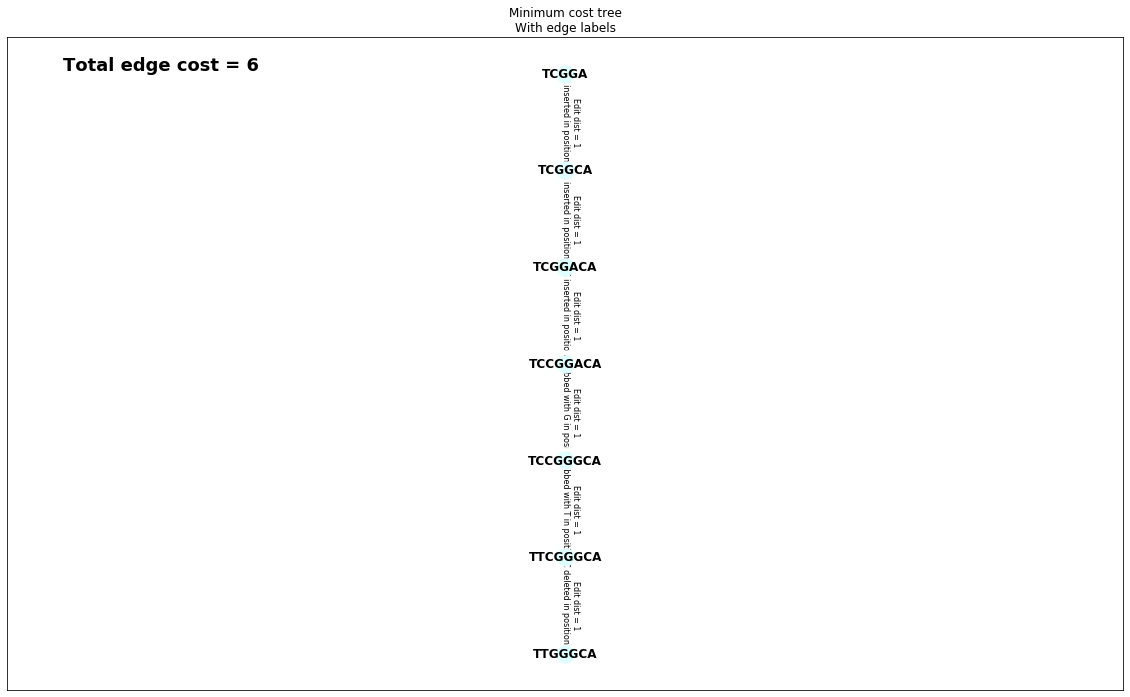

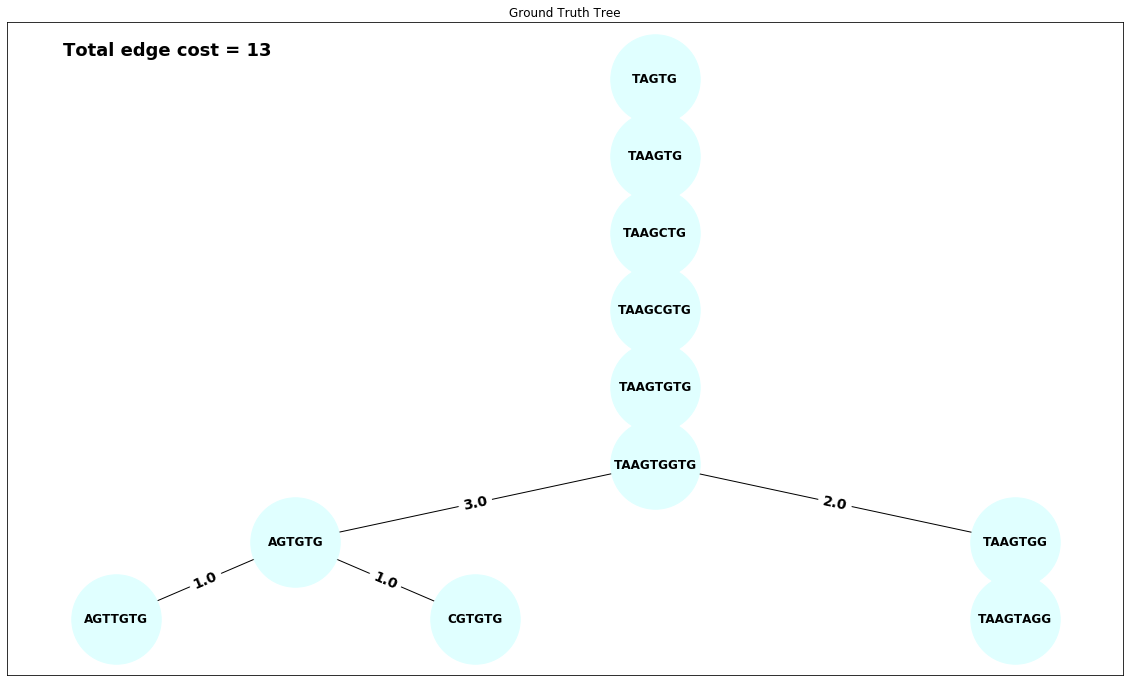

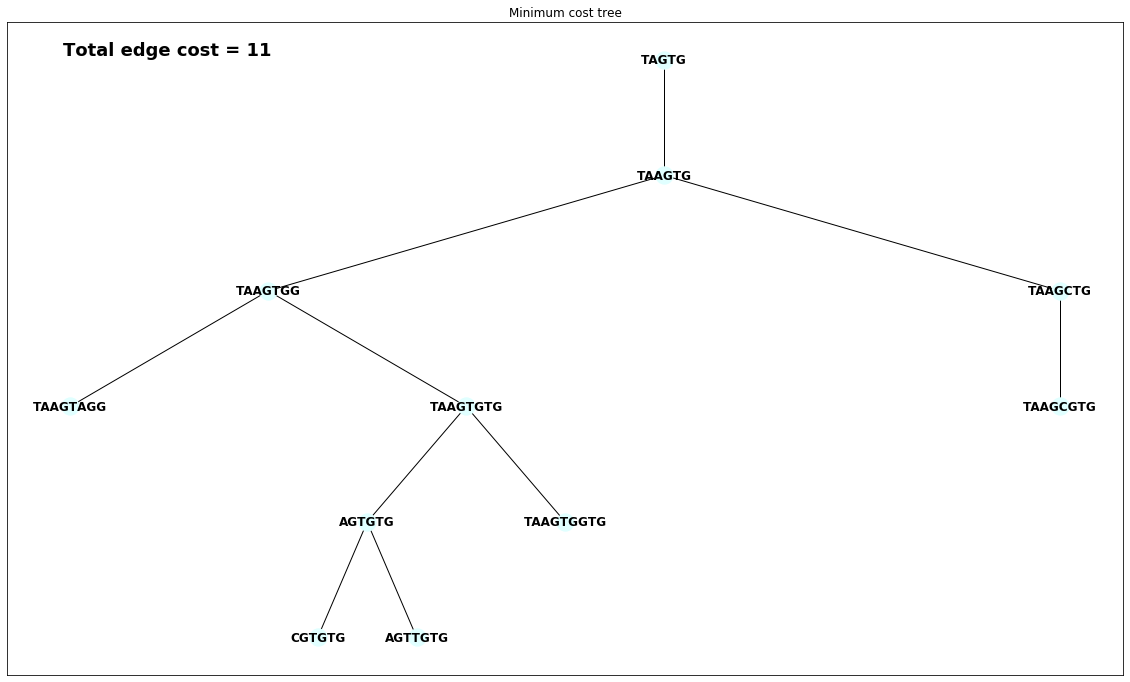

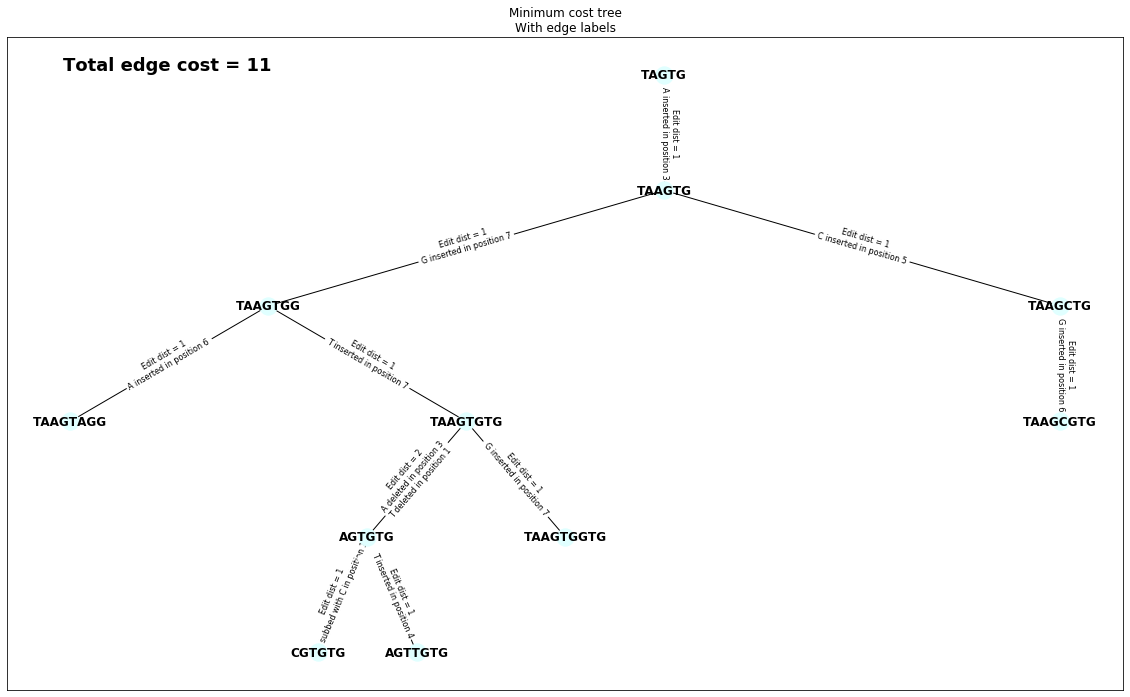

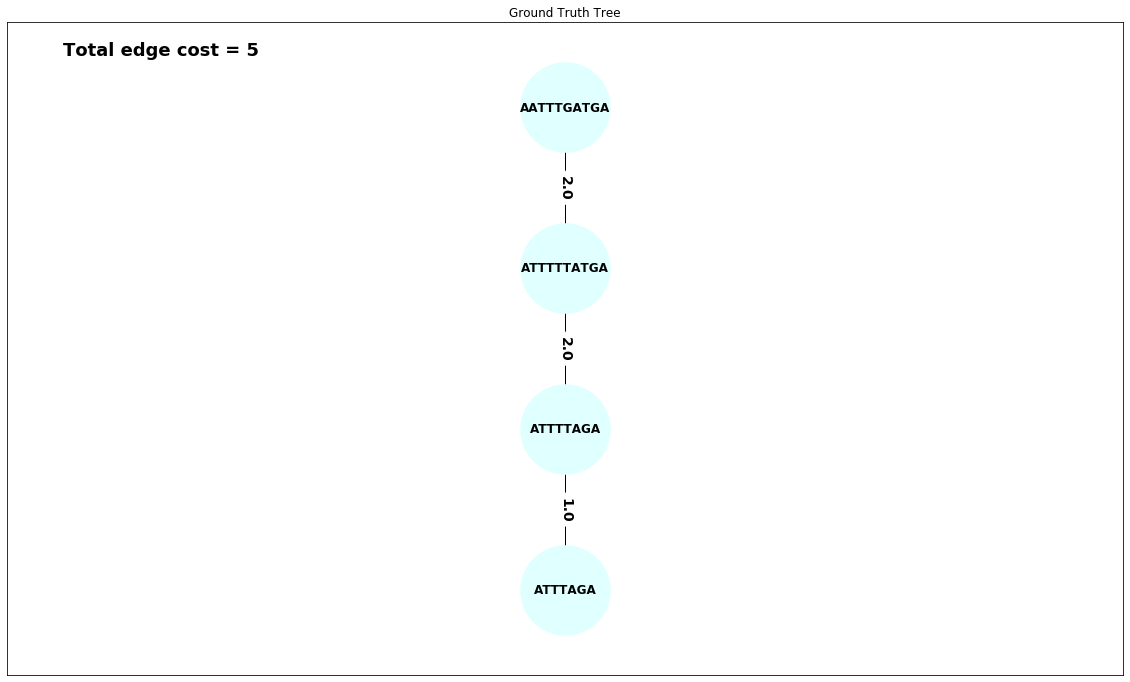

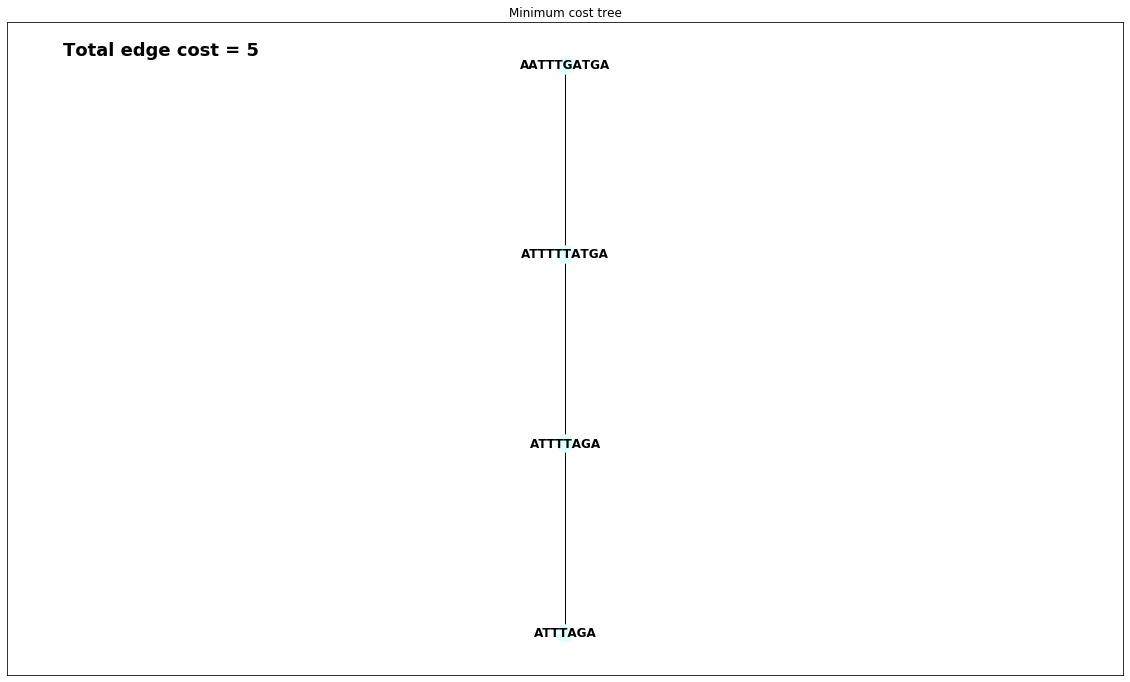

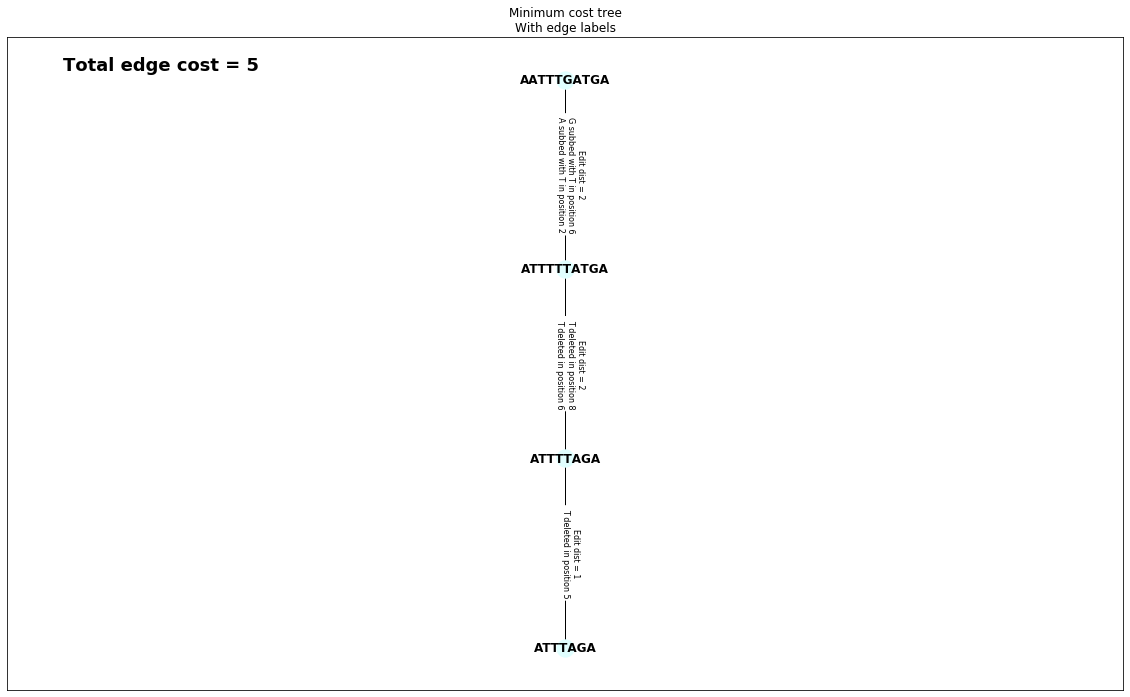

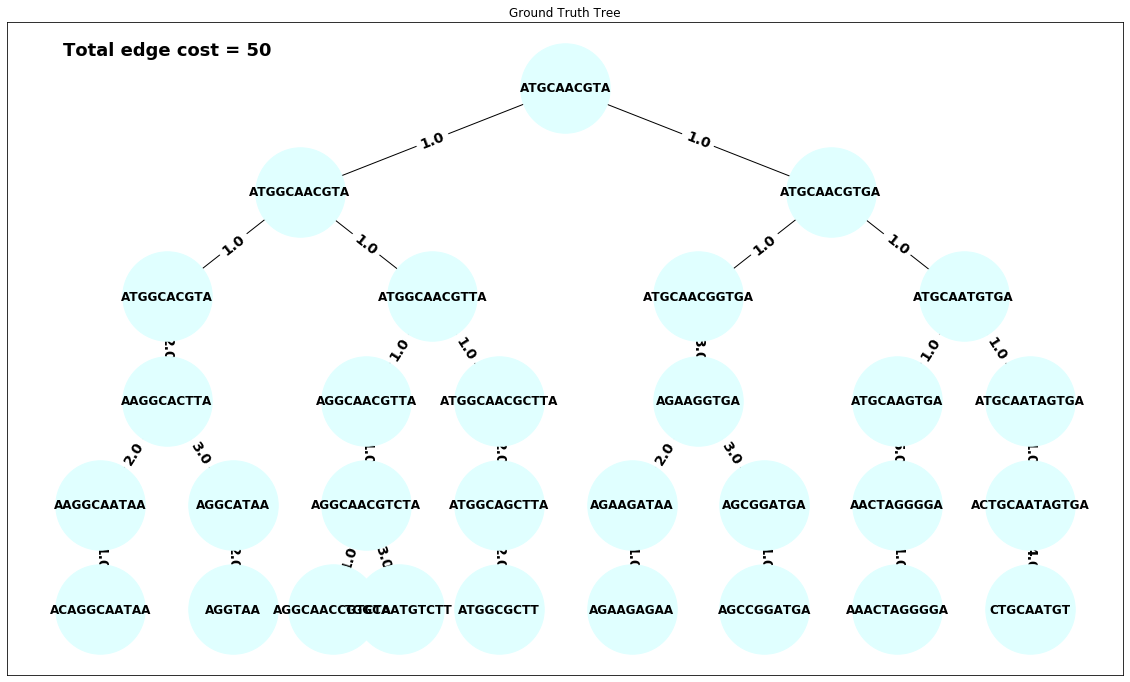

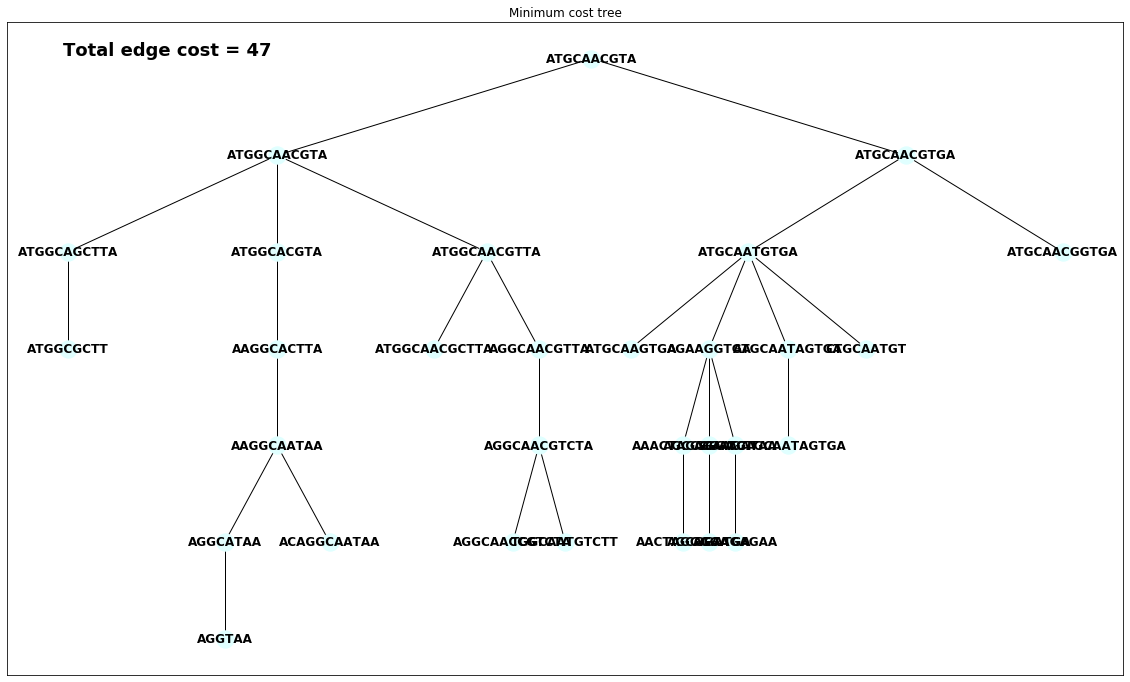

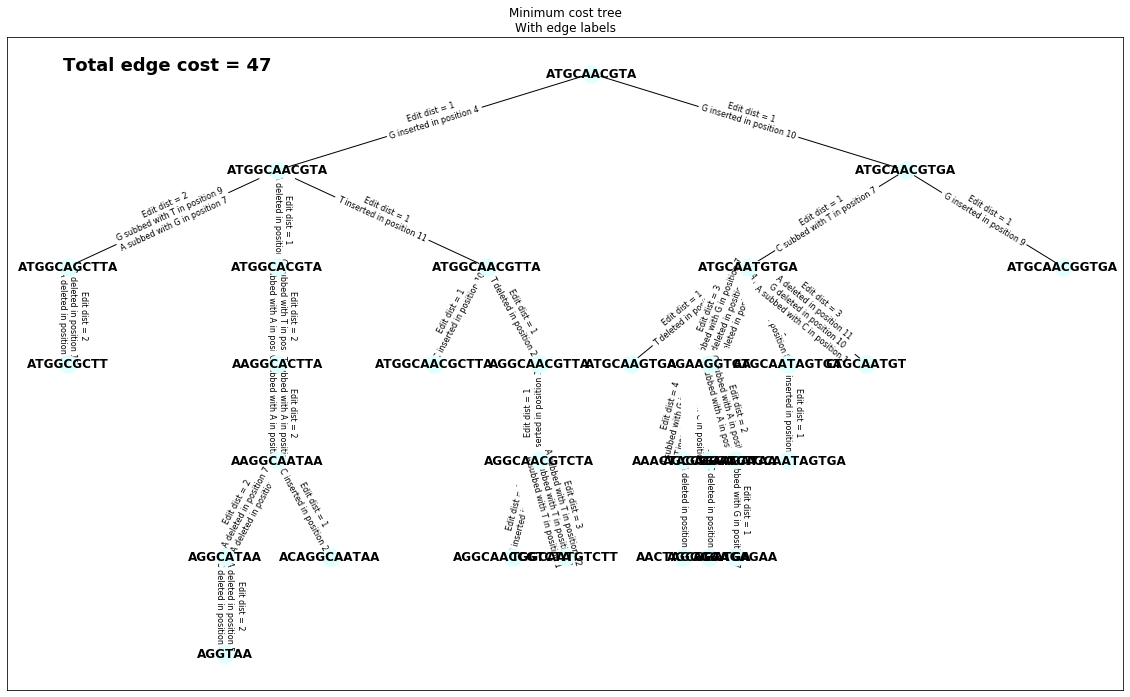

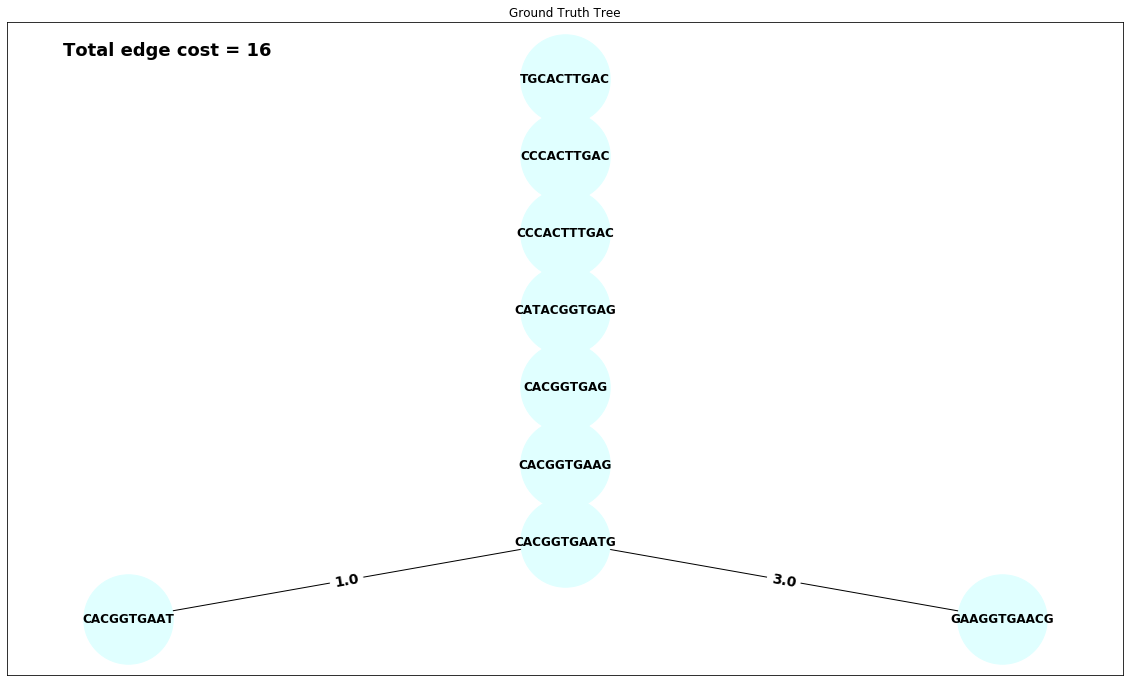

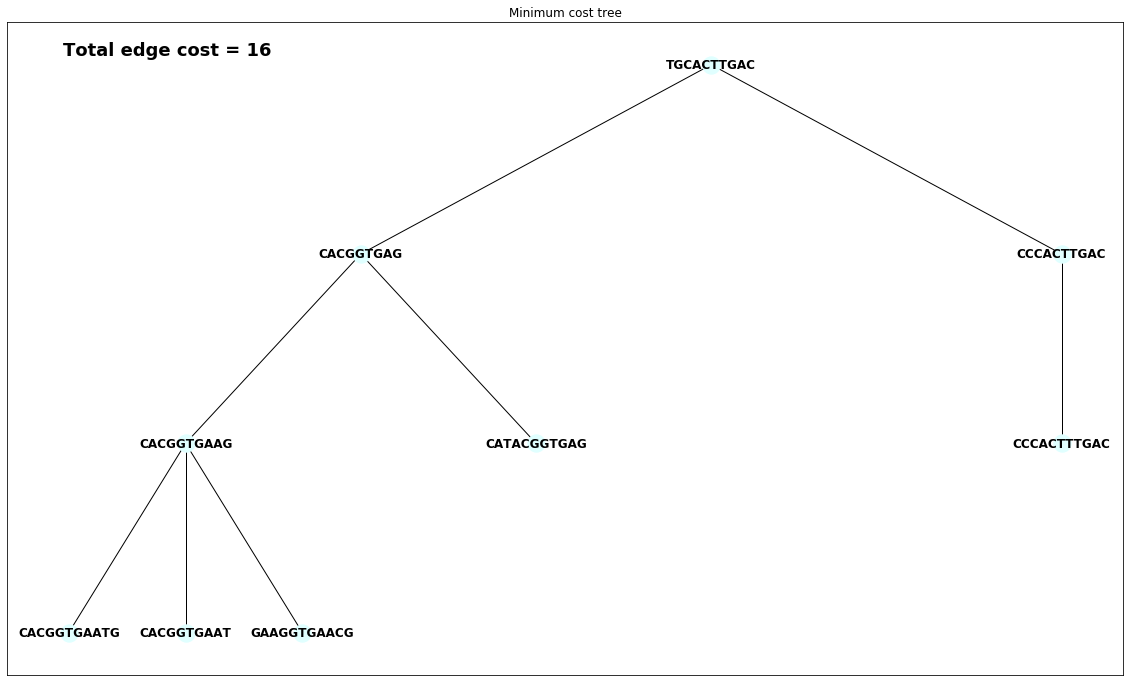

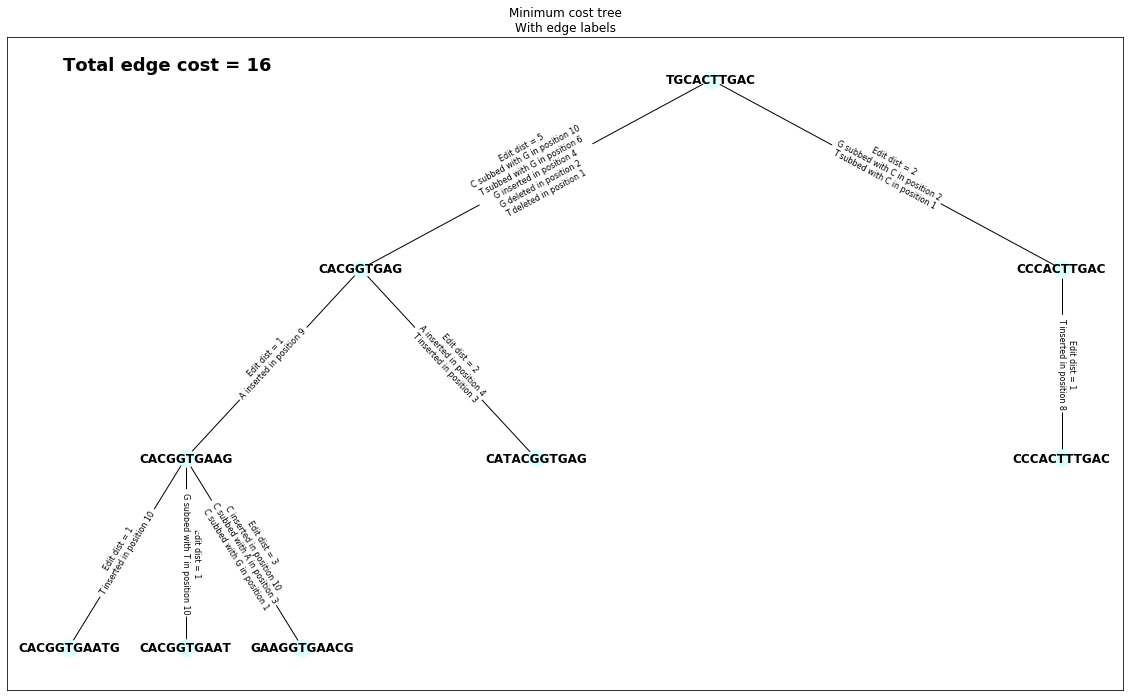

In [17]:
#Plots some example trees to be used in the report
n = [5,10]
gen = [4,6,8]
for i in range(len(n)):
        for j in range(len(gen)):
            minimum_cost_tree(n[i], gen[j])

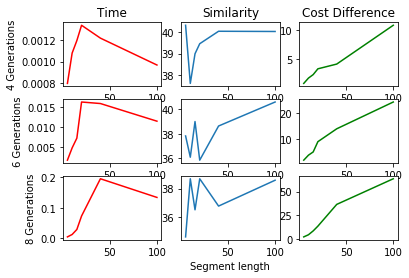

In [18]:
#Plots the data over segment length for different maximum numebr of generations
n = [ 5,10,15,20,40,100]
gen = [4,6,8]


fig = plt.figure()

plt.subplot(3, 3, 1)
plt.plot(n,Atime[:,0],'r')
plt.title('Time')
plt.ylabel('4 Generations')

plt.subplot(3, 3, 2)
plt.plot(n,Asim[:,0])
plt.title('Similarity')

plt.subplot(3, 3, 3)
plt.plot(n,Acost[:,0],'g')
plt.title('Cost Difference')

plt.subplot(3, 3, 4)
plt.plot(n,Atime[:,1],'r')
plt.ylabel('6 Generations')

plt.subplot(3, 3, 5)
plt.plot(n,Asim[:,1])


plt.subplot(3, 3, 6)
plt.plot(n,Acost[:,1],'g')

plt.subplot(3, 3, 7)
plt.plot(n,Atime[:,2],'r')
plt.ylabel('8 Generations')

plt.subplot(3, 3, 8)
plt.plot(n,Asim[:,2])
plt.xlabel('Segment length')
plt.subplot(3, 3, 9)
plt.plot(n,Acost[:,2],'g')

plt.show()


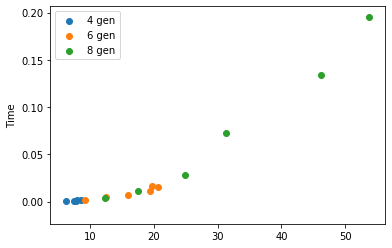

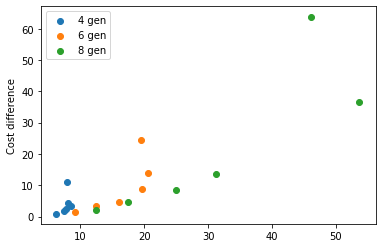

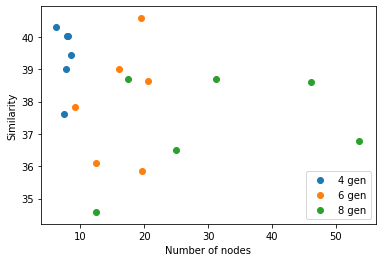

In [19]:
#Plots data over number of nodes (vertices)
plt.figure()

plt.scatter(Avert[:,0],Atime[:,0],label="4 gen")
plt.scatter(Avert[:,1],Atime[:,1],label="6 gen")
plt.scatter(Avert[:,2],Atime[:,2],label="8 gen")
plt.ylabel('Time')
plt.legend(loc="upper left")

plt.figure()

plt.scatter(Avert[:,0],Acost[:,0],label="4 gen")
plt.scatter(Avert[:,1],Acost[:,1],label="6 gen")
plt.scatter(Avert[:,2],Acost[:,2],label="8 gen")
plt.ylabel('Cost difference')
plt.legend(loc="upper left")

plt.figure()

plt.scatter(Avert[:,0],Asim[:,0],label="4 gen")
plt.scatter(Avert[:,1],Asim[:,1],label="6 gen")
plt.scatter(Avert[:,2],Asim[:,2],label="8 gen")
plt.ylabel('Similarity')
plt.xlabel('Number of nodes')
plt.legend(loc="lower right")